In [1]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/detailed_deep_learning/'
sys.path.append(CURR_DIR)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat import v1 as tf_v1
print(tf.version)
tf.compat.v1.disable_eager_execution()
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
np.random.seed(0)
tf.random.set_seed(1234)

In [4]:
def Inference(x_ph, batch_size_ph, max_t, n_hidden, n_out):
    # lstm_cell = tf_v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    lstm_cell = tf_v1.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0)
    init_hidden_sate = lstm_cell.zero_state(batch_size_ph, tf.float32)

    hidden_sate = init_hidden_sate
    hiddens = []
    with tf_v1.variable_scope('LSTM'):
        for t in range(max_t):
            if 0 < t:
                tf_v1.get_variable_scope().reuse_variables()

            lstm_cell_output, hidden_sate = lstm_cell(x_ph[:, t, :], hidden_sate)
            hiddens.append(lstm_cell_output)

    latest_hidden = hiddens[-1]
    
    W_out = tf.Variable(tf.random.truncated_normal([n_hidden, n_out], stddev=0.01))
    b_out = tf.Variable(tf.zeros([n_out], dtype=tf.float32))
    y = tf.matmul(latest_hidden, W_out) + b_out
    return y


def Loss(y, t_ph):
    mse = tf.reduce_mean(tf.square(y - t_ph))
    return mse


def Training(loss):
    optimizer = tf_v1.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

In [5]:
class EarlyStopping():
    def __init__(self, patience, verbose):
        self.step = 0
        self.loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self.loss < loss:
            self.step += 1
            if self.patience < self.step:
                if self.verbose:
                    print('Early stopping...')
                return True
        else:
            self.step = 0
            self.loss = loss
            
        return False


In [6]:
period = 100
ts = np.arange(2*period + 1)

noise = 0.05*np.random.uniform(low=-1.0, high=1.0, size=len(ts))
noisy_sin = np.sin(2.0*np.pi/period*ts) + noise

max_t = 25

data = []
target = []
for t in range(len(ts) - max_t):
    data.append(noisy_sin[t : t + max_t])
    target.append(noisy_sin[t + max_t])

data = np.array(data)
target = np.array(target)
print('data.shape =', data.shape)
print('target.shape =', target.shape)
print()

X = data.reshape(data.shape[0], data.shape[1], 1)
T = target.reshape(target.shape[0], 1)
print('X.shape =', X.shape)
print('T.shape =', T.shape)
print()

N_train = int(round(0.9 * len(data)))
N_valid = len(data) - N_train
X_train, X_valid, T_train, T_valid = sklearn.model_selection.train_test_split(X, T, test_size=N_valid)
print('X_train.shape =', X_train.shape, ', X_valid.shape =', X_valid.shape)
print()

data.shape = (176, 25)
target.shape = (176,)

X.shape = (176, 25, 1)
T.shape = (176, 1)

X_train.shape = (158, 25, 1) , X_valid.shape = (18, 25, 1)



In [7]:
n_in = len(X[0][0])
n_hidden = 30
n_out = len(T[0])

x_ph = tf_v1.placeholder(tf.float32, shape=[None, max_t, n_in])
batch_size_ph = tf_v1.placeholder(tf.int32, shape=[])
t_ph = tf_v1.placeholder(tf.float32, shape=[None, n_out])

y = Inference(x_ph, batch_size_ph, max_t, n_hidden, n_out)
loss = Loss(y, t_ph)
train_step = Training(loss)

early_stopping = EarlyStopping(patience=10, verbose=1)
history = {
    'valid_loss': [],
}

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
epochs = 300
batch_size = 10
n_batches = N_train // batch_size

init = tf_v1.global_variables_initializer()
sess = tf_v1.Session()
sess.run(init)

for epoch in range(epochs):
    X_shuffle, T_shuffle = sklearn.utils.shuffle(X_train, T_train)

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size

        sess.run(train_step, feed_dict={
            x_ph: X_shuffle[start:end],
            t_ph: T_shuffle[start:end],
            batch_size_ph: batch_size
        })

    valid_loss = loss.eval(session=sess, feed_dict={
        x_ph: X_valid,
        t_ph: T_valid,
        batch_size_ph: N_valid
    })

    history['valid_loss'].append(valid_loss)
    if epoch % 10 == 0:
        print('epoch =', epoch, ', valid_loss =', valid_loss)

    if early_stopping.validate(valid_loss):
        epochs = epoch + 1
        break

epoch = 0 , valid_loss = 0.3835739
epoch = 10 , valid_loss = 0.011608724
epoch = 20 , valid_loss = 0.0012430436
epoch = 30 , valid_loss = 0.0018279321
Early stopping...


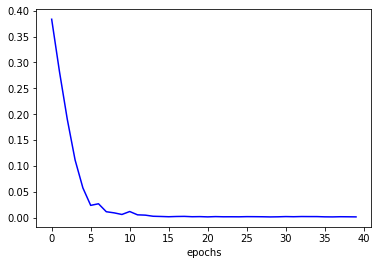

In [9]:
fig = plt.figure()
ax_loss = fig.add_subplot(1,1,1)
ax_loss.plot(range(epochs), history['valid_loss'], label='valid_loss', color='blue')
plt.xlabel('epochs')
plt.show()

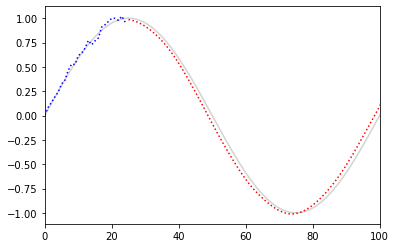

In [10]:
orig = [noisy_sin[i] for i in range(max_t)]
pred = [None for i in range(max_t)]

Z = X[0].reshape(1, max_t, n_in)
for i in range(len(ts) - max_t):
    latest_z = Z[-1].reshape(1, max_t, n_in)
    y_pred = y.eval(session=sess, feed_dict={
        x_ph: latest_z,
        batch_size_ph: 1
    })
    y_pred = y_pred[0, 0]
    # print(y_pred)

    new_z = np.append(latest_z[0, 1:, 0], y_pred).reshape(1, max_t, n_in)
    Z = np.append(Z, new_z, axis=0)
    pred.append(y_pred)

plt.figure()
plt.xlim([0, period])
plt.plot(noisy_sin - noise, color='lightgray')
plt.plot(orig, linestyle='dotted', color='blue')
plt.plot(pred, linestyle='dotted', color='red')
plt.show()
